In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LinearRegression

# Actual calculation

Since we have seen 2(hand) + 3(community) cards, the probability is 

$$
P = \frac{N}{47} \times \frac{N-1}{46} = \frac{N^2 - N}{47\times 46}
$$
and 
$$
P = \frac{N}{46}
$$

# Rule of 2 and 4
If you have $N$-out and 2 card are still left to be deal, the probability of getting the cards you need is $4 \times N$.

If you have $N$-out and 1 card are still left to be deal, the probability of getting the cards you need is $2 \times N$.

In [27]:
def calculate_probability(outs, cards_to_come):
    if cards_to_come == 1:
        return outs / 47
    elif cards_to_come == 2:
        p_turn = outs / 47
        p_river = (outs / 46) * (1 - p_turn)
        return p_turn + p_river
    return 0


outs_range = list(range(1, 21))
outs_array = np.array(outs_range).reshape(-1, 1)  # Reshape for sklearn

probs_1_card = [calculate_probability(outs, 1) for outs in outs_range]
probs_2_cards = [calculate_probability(outs, 2) for outs in outs_range]

reg_1_card = LinearRegression().fit(outs_array, np.array(probs_1_card))
reg_2_cards = LinearRegression().fit(outs_array, np.array(probs_2_cards))

slope_1_card = reg_1_card.coef_[0]
intercept_1_card = reg_1_card.intercept_
slope_2_cards = reg_2_cards.coef_[0]
intercept_2_cards = reg_2_cards.intercept_

r2_1_card = reg_1_card.score(outs_array, np.array(probs_1_card))
r2_2_cards = reg_2_cards.score(outs_array, np.array(probs_2_cards))

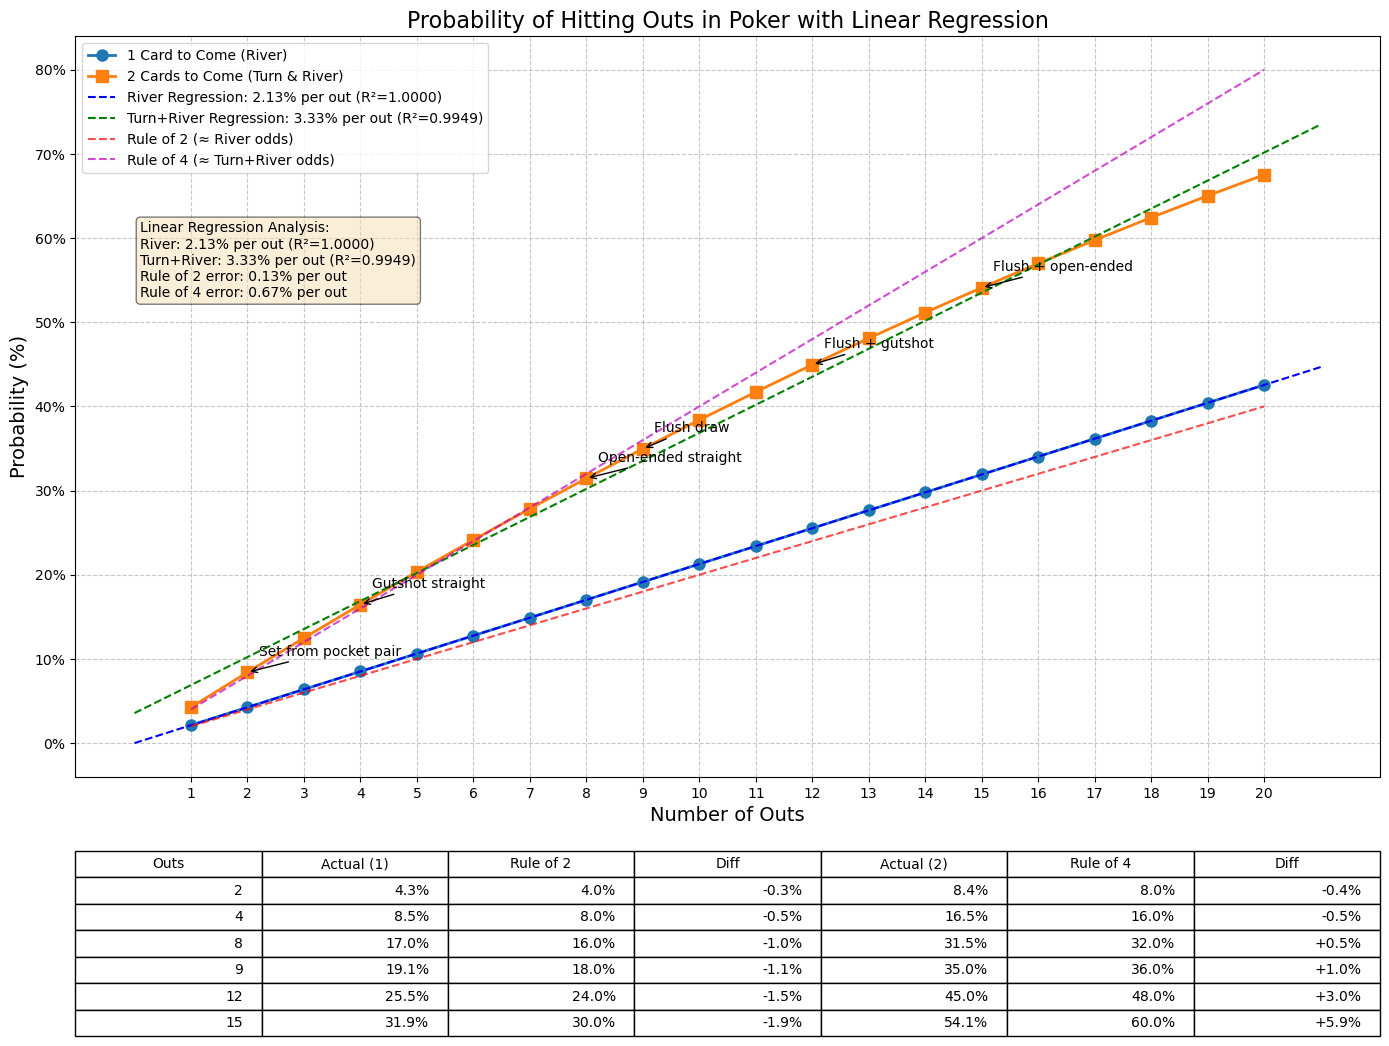

In [31]:
plt.figure(figsize=(14, 10))

plt.plot(outs_range, [p*100 for p in probs_1_card], 'o-', linewidth=2, markersize=8, 
         label='1 Card to Come (River)')
plt.plot(outs_range, [p*100 for p in probs_2_cards], 's-', linewidth=2, markersize=8, 
         label='2 Cards to Come (Turn & River)')

x_reg = np.linspace(0, 21, 100).reshape(-1, 1)
plt.plot(x_reg, (reg_1_card.predict(x_reg))*100, 'b--', linewidth=1.5, 
         label=f'River Regression: {slope_1_card*100:.2f}% per out (R²={r2_1_card:.4f})')
plt.plot(x_reg, (reg_2_cards.predict(x_reg))*100, 'g--', linewidth=1.5, 
         label=f'Turn+River Regression: {slope_2_cards*100:.2f}% per out (R²={r2_2_cards:.4f})')

plt.plot(outs_range, [outs*2 for outs in outs_range], 'r--', alpha=0.7, 
         label='Rule of 2 (≈ River odds)')
plt.plot(outs_range, [outs*4 for outs in outs_range], 'm--', alpha=0.7, 
         label='Rule of 4 (≈ Turn+River odds)')

common_outs = [2, 4, 8, 9, 12, 15]
common_outs_labels = {
    2: "Set from pocket pair",
    4: "Gutshot straight",
    8: "Open-ended straight",
    9: "Flush draw",
    12: "Flush + gutshot",
    15: "Flush + open-ended"
}

for outs in common_outs:
    prob_1 = calculate_probability(outs, 1) * 100
    prob_2 = calculate_probability(outs, 2) * 100
    
    plt.annotate(f"{common_outs_labels[outs]}", 
                xy=(outs, prob_2), 
                xytext=(outs+0.2, prob_2+2),
                arrowprops=dict(arrowstyle='->'))

textstr = '\n'.join((
    'Linear Regression Analysis:',
    f'River: {slope_1_card*100:.2f}% per out (R²={r2_1_card:.4f})',
    f'Turn+River: {slope_2_cards*100:.2f}% per out (R²={r2_2_cards:.4f})',
    f'Rule of 2 error: {abs(slope_1_card*100-2):.2f}% per out',
    f'Rule of 4 error: {abs(slope_2_cards*100-4):.2f}% per out'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.xlabel('Number of Outs', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Probability of Hitting Outs in Poker with Linear Regression', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper left')
plt.xticks(outs_range)
plt.gca().yaxis.set_major_formatter(PercentFormatter())

comparison_data = []
headers = ['Outs', 'Actual (1)', 'Rule of 2', 'Diff', 'Actual (2)', 'Rule of 4', 'Diff']
for outs in [2, 4, 8, 9, 12, 15]:
    actual_1 = calculate_probability(outs, 1) * 100
    rule_2 = outs * 2
    diff_1 = rule_2 - actual_1
    
    actual_2 = calculate_probability(outs, 2) * 100
    rule_4 = outs * 4
    diff_2 = rule_4 - actual_2
    
    comparison_data.append([outs, f"{actual_1:.1f}%", f"{rule_2:.1f}%", f"{diff_1:+.1f}%", 
                           f"{actual_2:.1f}%", f"{rule_4:.1f}%", f"{diff_2:+.1f}%"])

plt.table(cellText=comparison_data,
          colLabels=headers,
          loc='bottom',
          bbox=[0.0, -0.35, 1.0, 0.25])

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()